In [195]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import PolynomialFeatures

from sklearn.impute import KNNImputer

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import warnings 
warnings.filterwarnings('ignore')

In [196]:
df = pd.read_csv('/kaggle/input/housedata/data.csv')
df.head(10)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
5,2014-05-02 00:00:00,490000.0,2.0,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,522 NE 88th St,Seattle,WA 98115,USA
6,2014-05-02 00:00:00,335000.0,2.0,2.00,1350,2560,1.0,0,0,3,1350,0,1976,0,2616 174th Ave NE,Redmond,WA 98052,USA
7,2014-05-02 00:00:00,482000.0,4.0,2.50,2710,35868,2.0,0,0,3,2710,0,1989,0,23762 SE 253rd Pl,Maple Valley,WA 98038,USA
8,2014-05-02 00:00:00,452500.0,3.0,2.50,2430,88426,1.0,0,0,4,1570,860,1985,0,46611-46625 SE 129th St,North Bend,WA 98045,USA
9,2014-05-02 00:00:00,640000.0,4.0,2.00,1520,6200,1.5,0,0,3,1520,0,1945,2010,6811 55th Ave NE,Seattle,WA 98115,USA


# Step 1: Data cleaning.

In this section we will check for missing values, duplicates rows and we will change the data type if it is necessary.

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [198]:
# Check for duplicates.
duplicates = df.duplicated()

if duplicates.empty:
    print("We have duplicates values.")
    df.drop_duplicates(inplace = True)
else:
    print("we don't have duplicates.")
    
# Check for missing values.
if df.isna().any().any():
    print('We have missing values.')
else:
    print("We don't have missing values.")


we don't have duplicates.
We don't have missing values.


The feature statezip, is not helping us for predictions so we drop this. We also decide to drop the 'street' feature. If our model is not good we comeback and handle this feature.


In [199]:
df.drop(['statezip','street'],axis =1, inplace = True)

Change the data type of the 'date' column

In [200]:
# Change the datatypes. 
df['date'] = pd.to_datetime(df['date'])


# Step 2: Explanatory Data Analysis. 

In [201]:
df.describe()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4600,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,2014-06-07 03:14:42.782608640,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
min,2014-05-02 00:00:00,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,2014-05-21 00:00:00,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,2014-06-09 00:00:00,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,2014-06-24 00:00:00,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2014-07-10 00:00:00,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000
std,NaN,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536


## Check the distribution of the Target feature which is price
Check the distribution and the possible outliers of the price column.

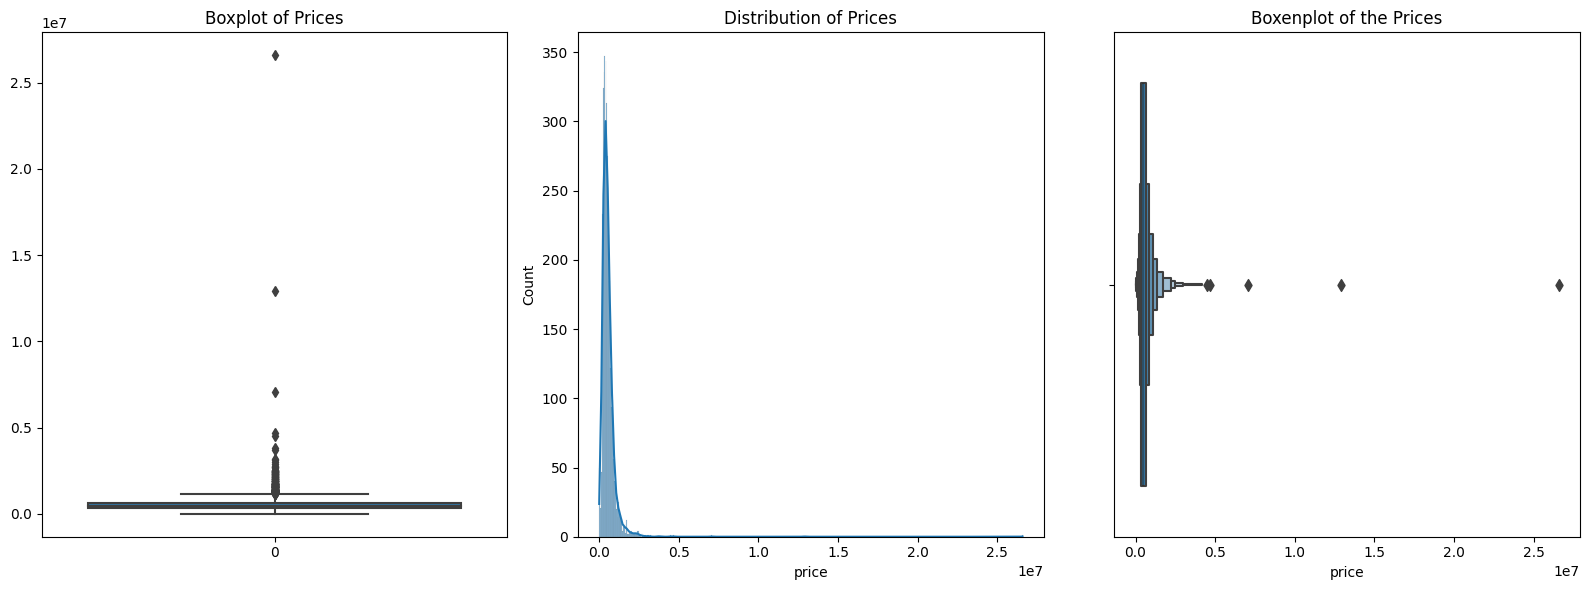

In [202]:
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

# Boxplot
sns.boxplot(data=df['price'], ax=ax[0])
ax[0].set_title('Boxplot of Prices')

# Distribution plot
sns.histplot(df['price'], kde=True, ax=ax[1])  # sns.distplot is deprecated; use sns.histplot with kde=True instead
ax[1].set_title('Distribution of Prices')

sns.boxenplot(x = df['price'])
ax[2].set_title('Boxenplot of the Prices')

# Adjust the layout
plt.tight_layout()

# Show the plots|
plt.show()

From the above plots we can see that he distribution of the vriable is not good. We have outliers, so we need to handle this.


In [203]:
# Check if we have houses with price 80000.
zero_price = df.iloc[np.where(df['price'] < 80000)]
print(f'We have {zero_price.shape[0]} which price is 0!! This is not acceptable.')

# Check how many house's price is bigger than 2 million dollars.
two_million_price = df.iloc[np.where(df['price'] > 2000000)]

print(f'We have {two_million_price.shape[0]} houses which price is extremely high!!')


We have 50 which price is 0!! This is not acceptable.
We have 47 houses which price is extremely high!!


## We will also drop the houses whose price are above 2 million dollars.
## After trial and error we decide just to drop those values, because the r square is higher by dropping them.

In [204]:
# Every house that has price bigger than 2 million, replace it with nan
#df['price'] = np.where(df['price'] > 2000000, np.nan,df['price'])

# Every house that has price equal to zero, replace it with nan.
#df['price'] = np.where(df['price'] <80000, np.nan,df['price'])


""" We have 2 options. Fill the missing values with the mean, or use the KNN to fill the missing values.
    At the begginning we fill them by using the KNN imputer and we will comeback if the result isn't good.
"""
# Fill the missing values with the mean values.
#df['price'].fillna(df['price'].mean(),inplace = True)

'''# Isolate the 'price' column
price_df = df[['price']]

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=2)

# Fit and transform the 'price' column to fill missing values
filled_price = imputer.fit_transform(price_df)

# Merge the filled 'price' column back into the original DataFrame
df['price'] = filled_price'''

# Create a new dataset and drop some values
df = df[(df['price']> 80000) & (df['price']< 2000000) ]


Visualize the distribution of the numerical features of the data. Also return the boxplot of this features.

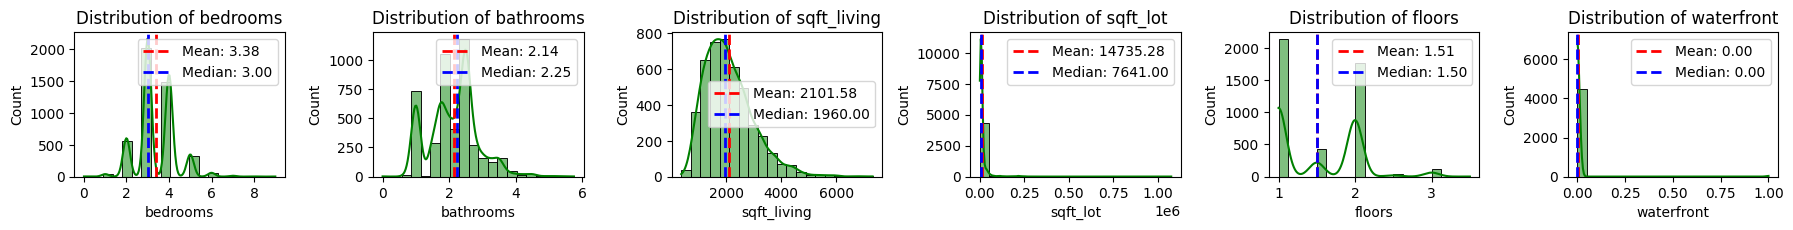

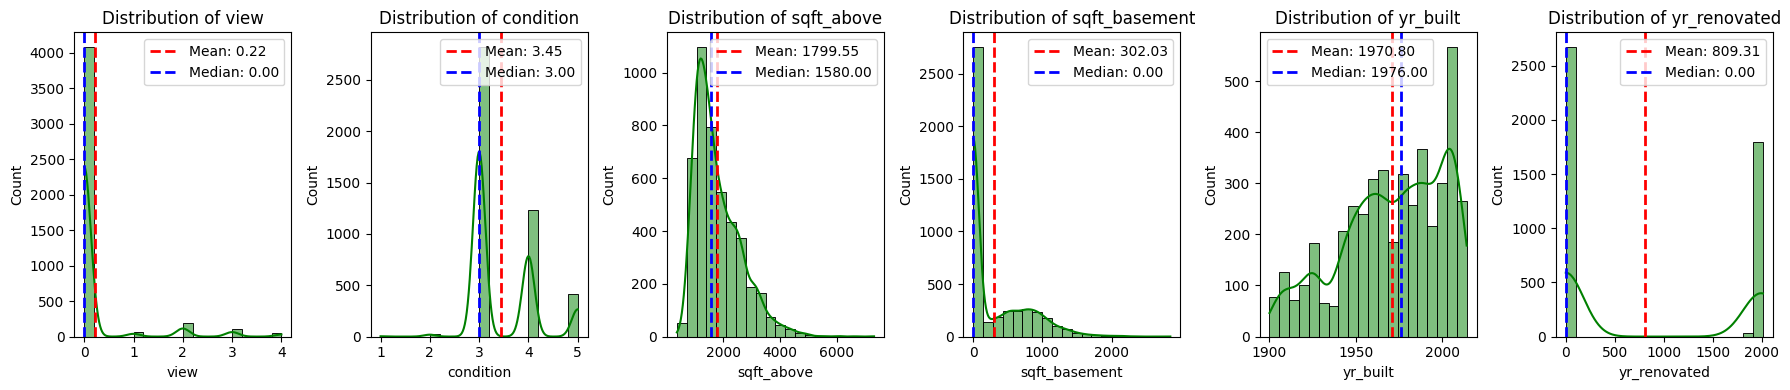

In [205]:
numerical_columns = df.select_dtypes(include=('int', 'float')).columns.to_list()
numerical_columns.remove('price')
categorical_columns = df.select_dtypes(exclude = ('int','float')).columns.to_list()
num_numerical_columns = len(numerical_columns)
columns_per_figure = 6  # Number of columns to plot per figure

# Loop through numerical columns and plot distributions
for i in range(0, num_numerical_columns, columns_per_figure):
    columns_subset = numerical_columns[i:i+columns_per_figure]
    
    # Create a new figure
    plt.figure(figsize=(18, 4))
    
    for j, column in enumerate(columns_subset, start=1):
        plt.subplot((num_numerical_columns - i - 1) // columns_per_figure + 1, columns_per_figure, j)
        
        # Check the distribution of each numerical column
        sns.histplot(data=df, x=column, bins=20, color='green', edgecolor='black', kde=True)
        
        # Calculate mean and median
        mean_value = df[column].mean()
        median_value = df[column].median()
        
        # Add mean and median lines
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
        plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
        
        # Set title and labels
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Count")
        plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the figure
    plt.show()

Some numerical features has outliers and in some columns we need to perform some feature enginering. For exaple, in years renovated featrues we have some values equal to zero. This means that the house never renovated.


## **Note**
### We can clearly see that we have many outliers in several columns. Because of the fact that our dataset has many rows, we decide to leave outliers.
### If our model doesn't work as we want we will handle the outliers. 

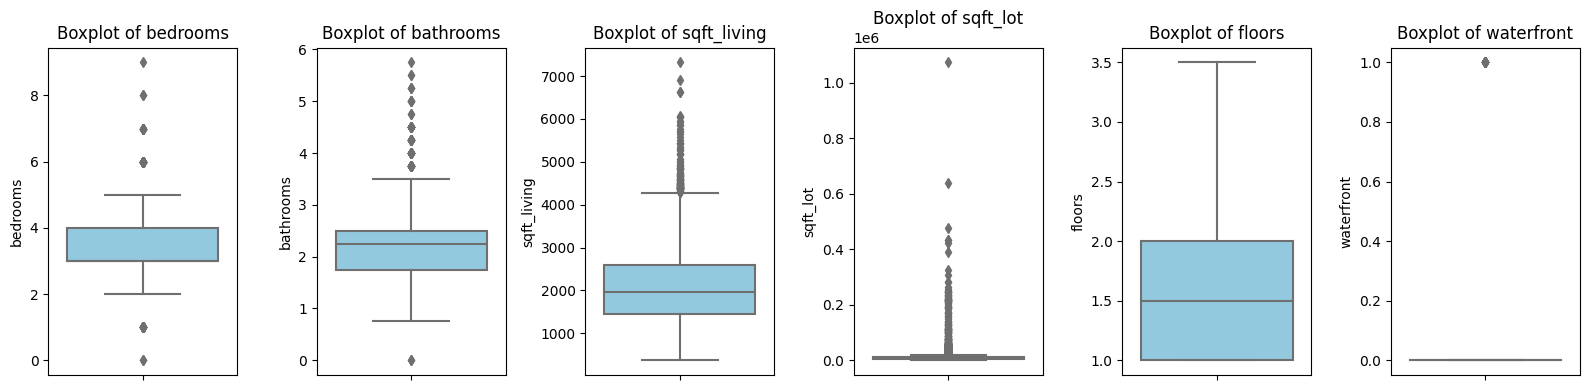

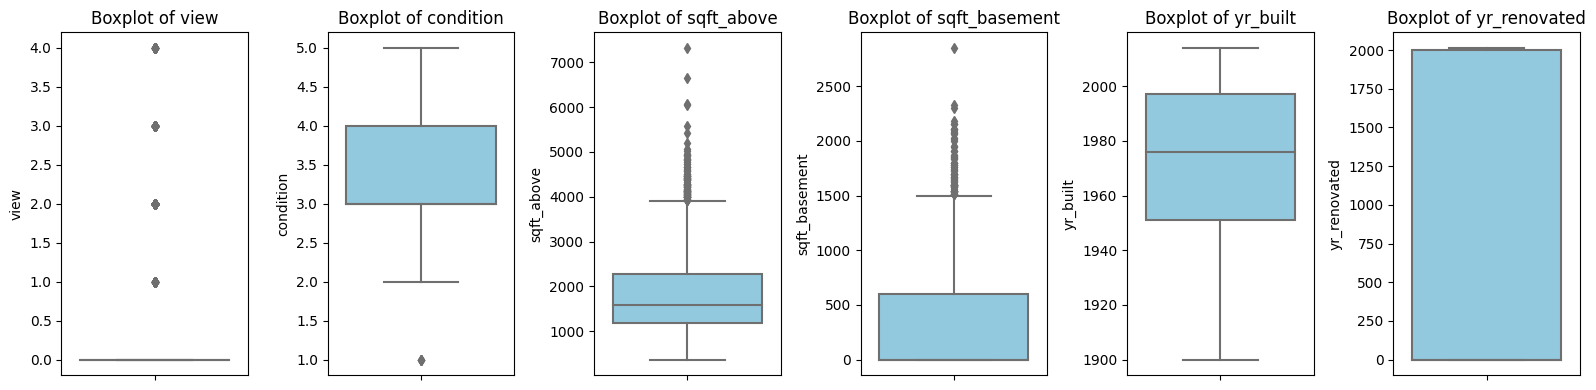

In [206]:
# Number of columns to plot per figure
columns_per_figure = 6

# Loop through numerical columns and plot distributions
for i in range(0, len(numerical_columns), columns_per_figure):
    columns_subset = numerical_columns[i:i+columns_per_figure]
    
    # Create a new figure for boxplots
    plt.figure(figsize=(16, 4))
    
    for j, column in enumerate(columns_subset, start=1):
        plt.subplot((len(columns_subset) - 1) // columns_per_figure + 1, columns_per_figure, j)
        
        # Plot boxplot for each numerical column
        sns.boxplot(data=df, y=column, color='skyblue')
        
        # Set title and labels
        plt.title(f"Boxplot of {column}")
        plt.ylabel(column)
        plt.xlabel("")
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the figure
    plt.show()

Explore the categorical features. 

We can see that we have many different cities, so we need to group them. Also we can see that we have house only in U.S.A. so we this feature is not useful.

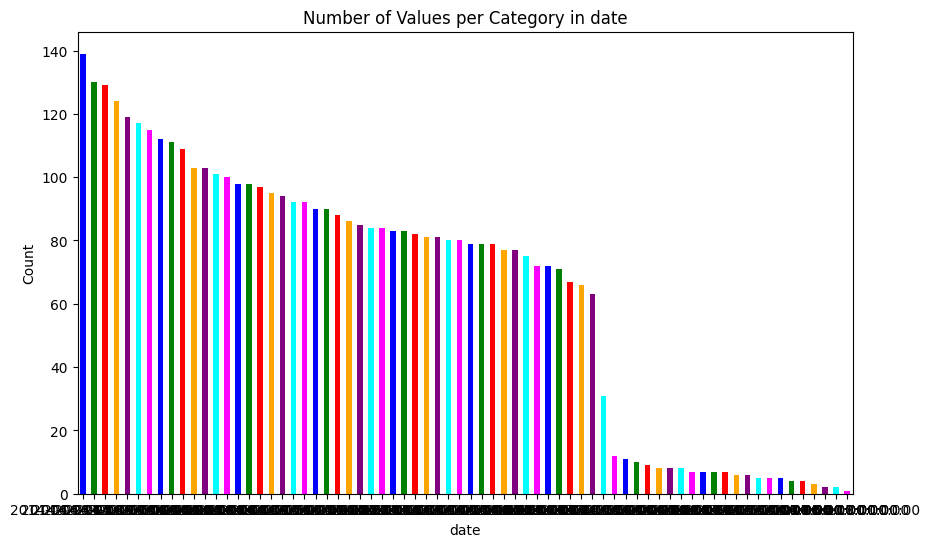

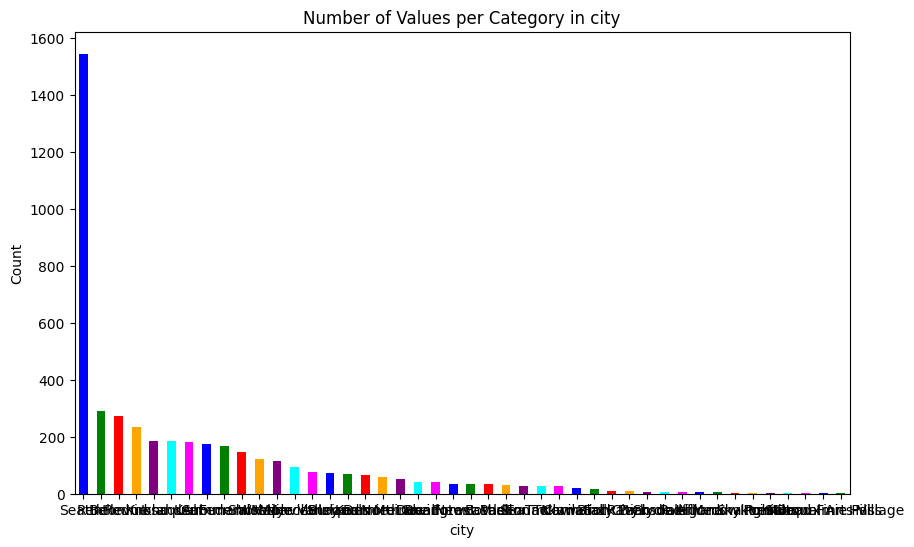

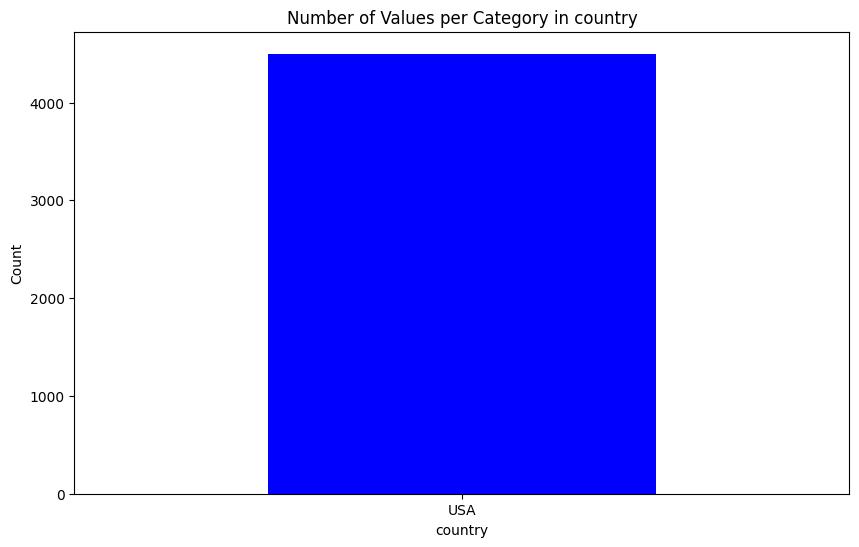

In [207]:
for column in categorical_columns:
    # Count the number of occurrences per category
    category_counts = df[column].value_counts()
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='bar', color=['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta'])
    plt.title(f'Number of Values per Category in {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=0)  # Keeps the x-axis labels horizontal
    plt.show()

In [208]:
# We can see that all the houses are in usa. So the country column will not help us for predictions.
# We drop this column
df.drop(['country'],axis =1, inplace = True)

Let's start exploring the bedrooms column.
We may need to perform feature engineering to this column to help us.

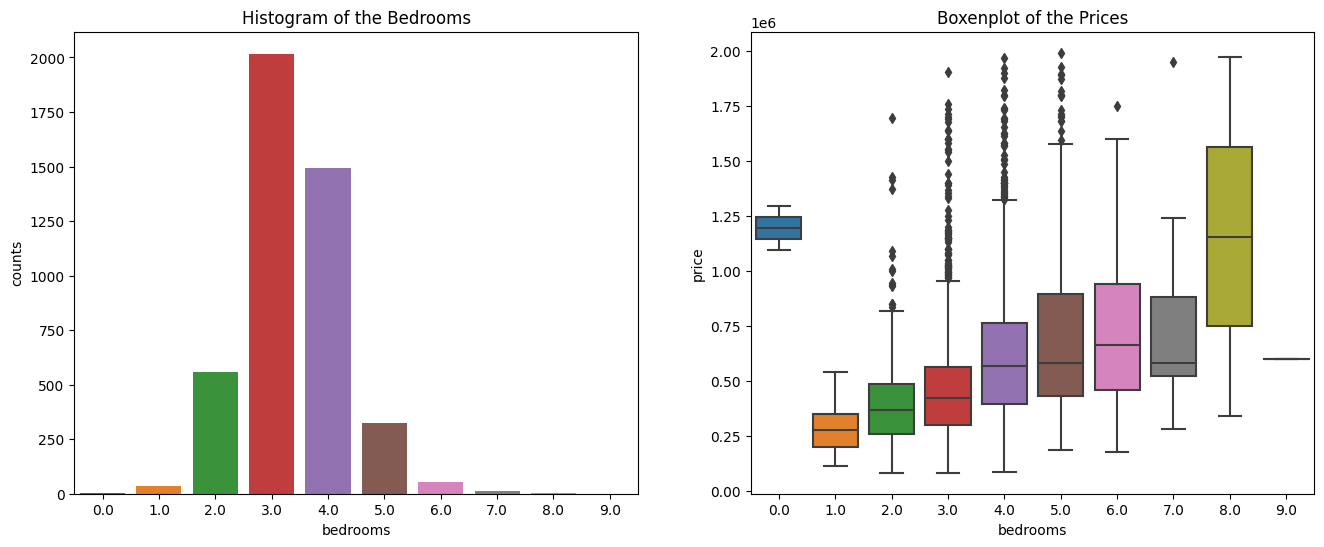

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

bedrooms
0.0       2
1.0      36
2.0     560
3.0    2017
4.0    1492
5.0     323
6.0      55
7.0      12
8.0       2
9.0       1
Name: count, dtype: int64

In [209]:
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(16, 6))


# Assuming df_price_drop is your DataFrame
bedroom_counts = df['bedrooms'].value_counts().sort_index()  # Sort the index to ensure the histogram is ordered

# Convert to a DataFrame for easier plotting
bedroom_counts_df = bedroom_counts.reset_index()
bedroom_counts_df.columns = ['bedrooms', 'counts']

# Plotting the sorted counts as a histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='bedrooms', y='counts', data=bedroom_counts_df,ax = ax[0])
ax[0].set_title('Histogram of the Bedrooms')

# Visualize the price per bedroom
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='bedrooms', y='price', ax = ax[1])
ax[1].set_title('Boxenplot of the Prices')

# Adjust the layout
plt.tight_layout()

# Show the plots|
plt.show()
bedroom_counts

Check the bathrooms of a house.

By Visualizing how many bathrooms a house has, we can see strange values. For example, is it possible a house to have 2.5 bathrooms ? or maybe 5.75 ?
Let's Round this featrue and visualize them again


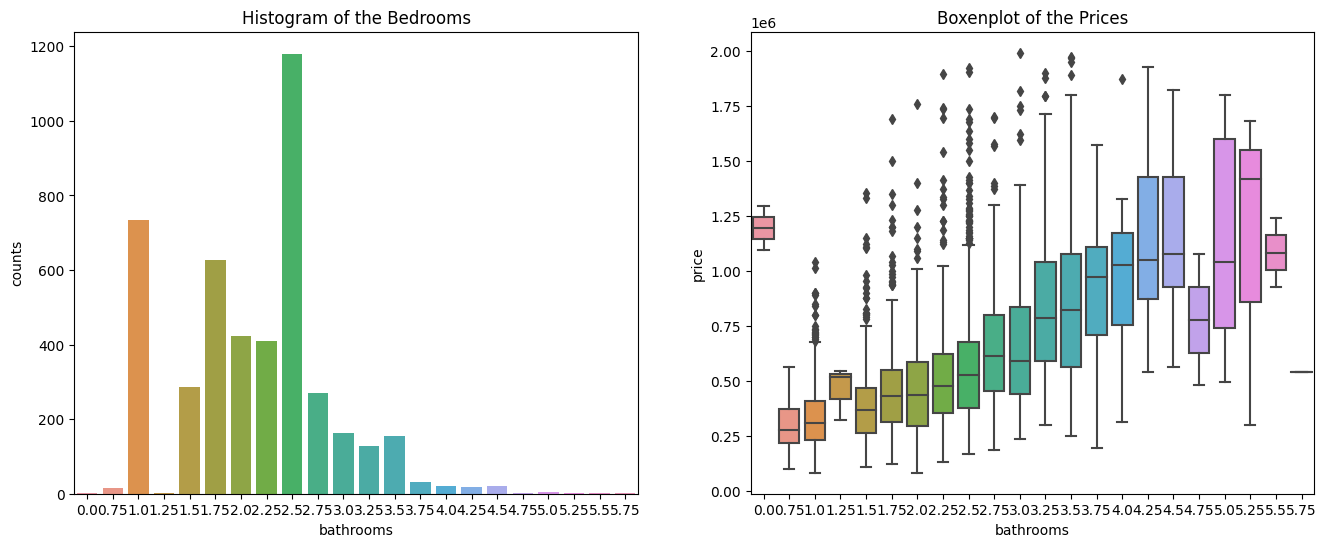

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [210]:
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(16, 6))


# Assuming df_price_drop is your DataFrame
bedroom_counts = df['bathrooms'].value_counts().sort_index()  # Sort the index to ensure the histogram is ordered

# Convert to a DataFrame for easier plotting
bathrooms_df = bedroom_counts.reset_index()
bathrooms_df.columns = ['bathrooms', 'counts']

# Plotting the sorted counts as a histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='bathrooms', y='counts', data=bathrooms_df,ax = ax[0])
ax[0].set_title('Histogram of the Bedrooms')

# Visualize the price per bedroom
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='bathrooms', y='price', ax = ax[1])
ax[1].set_title('Boxenplot of the Prices')

# Adjust the layout
plt.tight_layout()

# Show the plots|
plt.show()


After roundinf the variables, we can see the results.

We may need to apply some feature engineering to this feature.

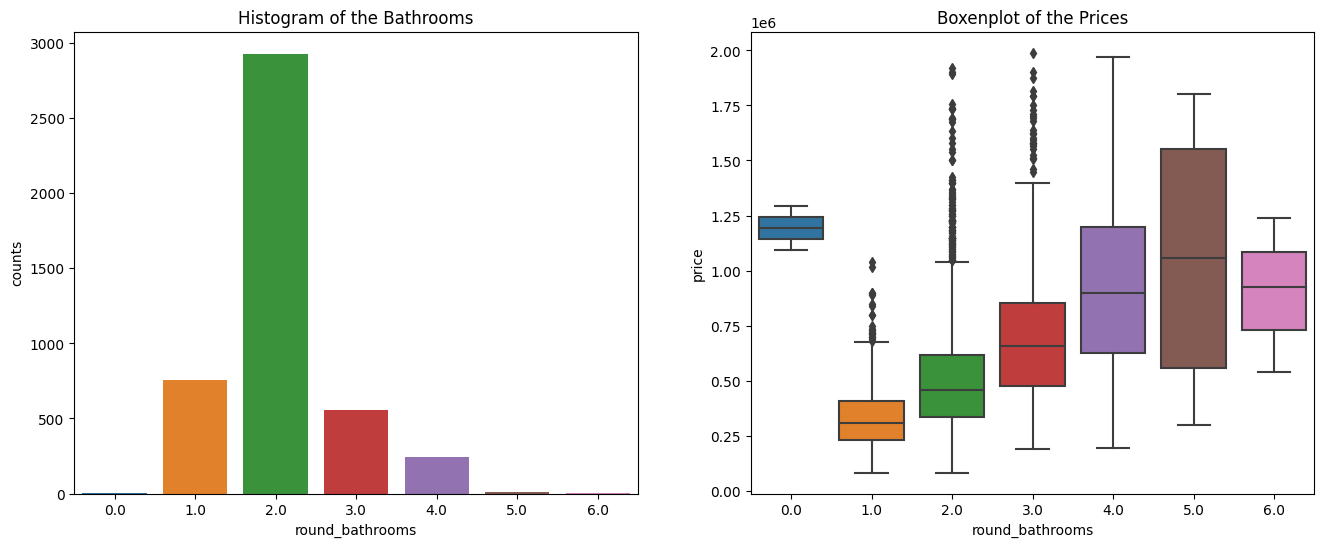

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

round_bathrooms
0.0       2
1.0     753
2.0    2927
3.0     559
4.0     246
5.0      10
6.0       3
Name: count, dtype: int64

In [211]:
df['round_bathrooms'] = df['bathrooms'].round()
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(16, 6))


# Assuming df_price_drop is your DataFrame
bedroom_counts = df['round_bathrooms'].value_counts().sort_index()  # Sort the index to ensure the histogram is ordered

# Convert to a DataFrame for easier plotting
bedroom_counts_df = bedroom_counts.reset_index()
bedroom_counts_df.columns = ['round_bathrooms', 'counts']

# Plotting the sorted counts as a histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='round_bathrooms', y='counts', data=bedroom_counts_df,ax = ax[0])
ax[0].set_title('Histogram of the Bathrooms')

# Visualize the price per bedroom
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='round_bathrooms', y='price', ax = ax[1])
ax[1].set_title('Boxenplot of the Prices')

# Adjust the layout
plt.tight_layout()

# Show the plots|
plt.show()
bedroom_counts

Let's visualize how many houses has waterfont. From the visualization we can see that this feature might not be significant 

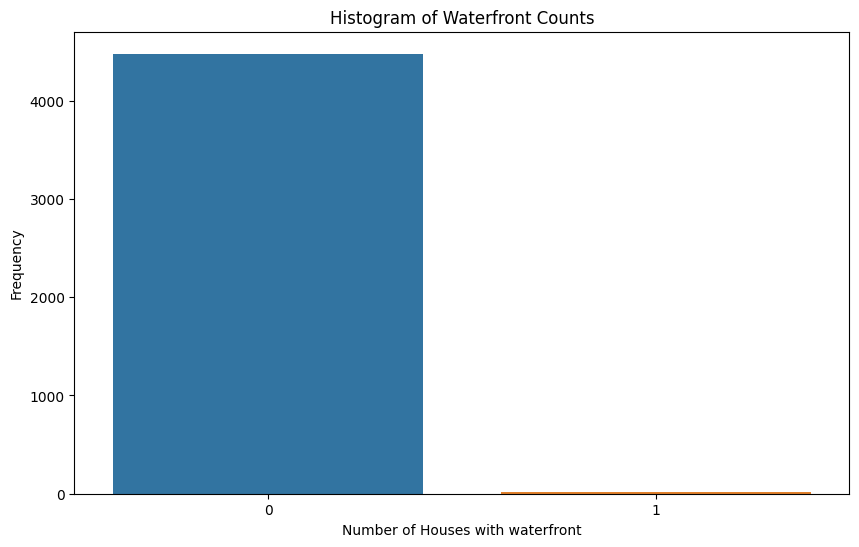

In [212]:
# Assuming df_price_drop is your DataFrame
bedroom_counts = df['waterfront'].value_counts().sort_index()  # Sort the index to ensure the histogram is ordered

# Convert to a DataFrame for easier plotting
waterfont_df = bedroom_counts.reset_index()
waterfont_df.columns = ['waterfront', 'counts']

# Plotting the sorted counts as a histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='waterfront', y='counts', data=waterfont_df)
plt.title('Histogram of Waterfront Counts')
plt.xlabel('Number of Houses with waterfront')
plt.ylabel('Frequency')
plt.show()

## Let's focus on the different cities.
### From the upcoming result, we can clearly see that we have one option and this is feature engineering based on geographical regions.

In [213]:
df['city'].value_counts().head()

city
Seattle     1546
Renton       291
Bellevue     273
Redmond      234
Kirkland     185
Name: count, dtype: int64

## Correlation
### We can check the correlation in numerical columns.


<Axes: >

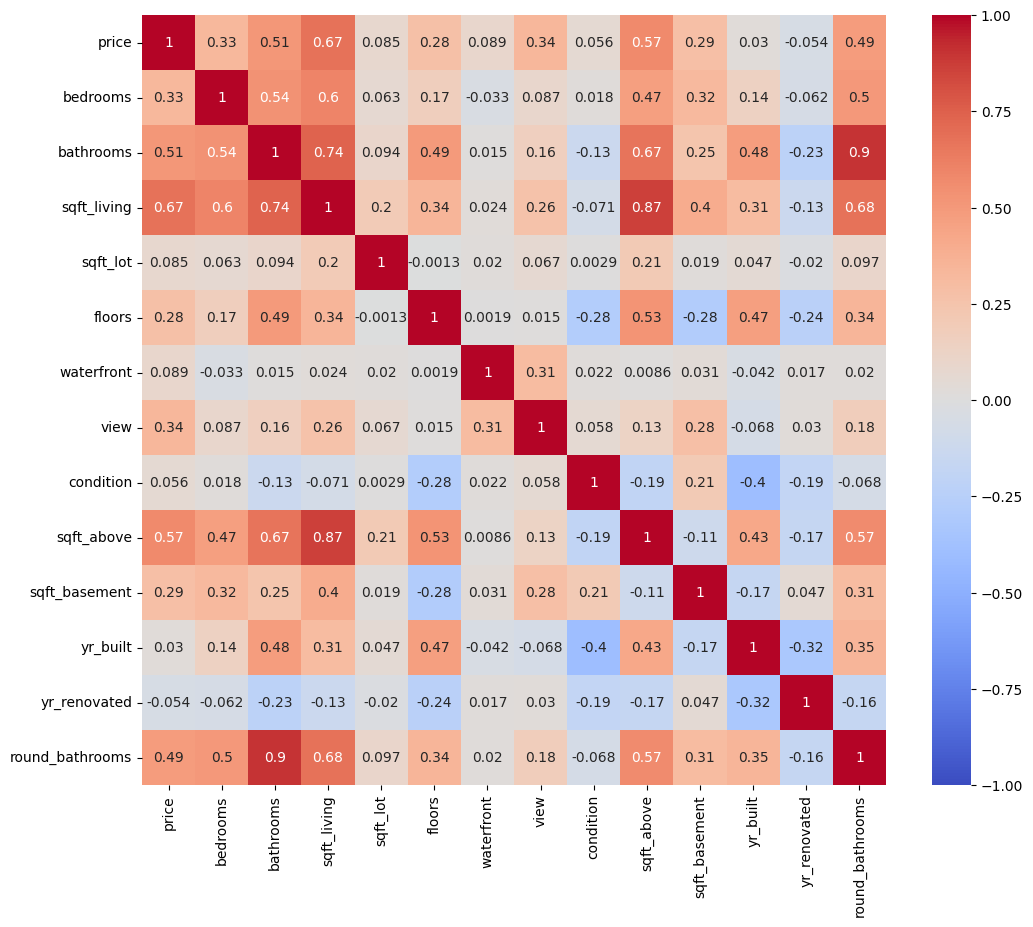

In [214]:
plt.figure(figsize=(12, 10))

sns.heatmap(df.corr(numeric_only= True),annot = True, vmin= -1, vmax = 1,cmap="coolwarm",)

Create a new column by extracting the months from the date feature.

Then we visualize the how the price changes between the months. We can see that the price of a house doesn't change through the different months of the year.

months
6    2135
5    1728
7     637
Name: count, dtype: int64


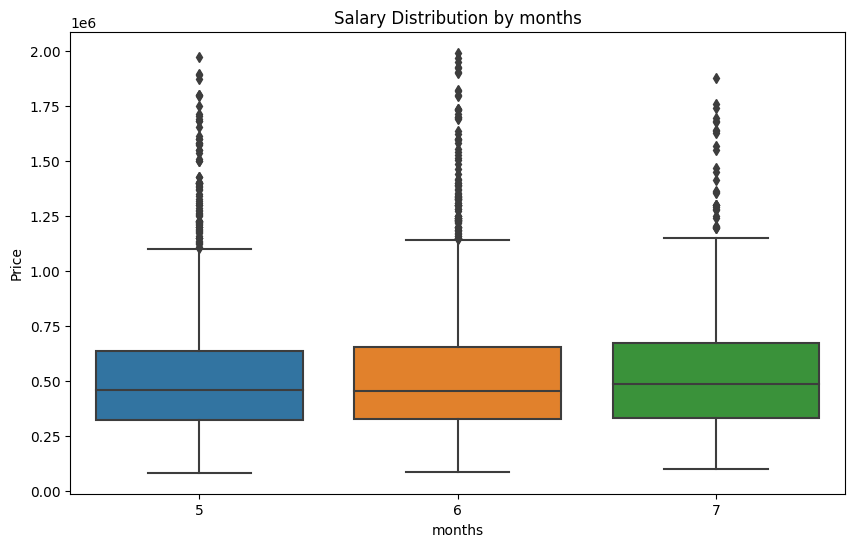

In [215]:
# Take the month from the date features
df['months'] = df['date'].dt.month

# Let's count the months
print(df['months'].value_counts())

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='months', y='price')
plt.title('Salary Distribution by months')
plt.xlabel('months')
plt.ylabel('Price')
plt.show()


# Πόσα χρόνια είχε να ανακαινιστεί


<Axes: xlabel='count', ylabel='Count'>

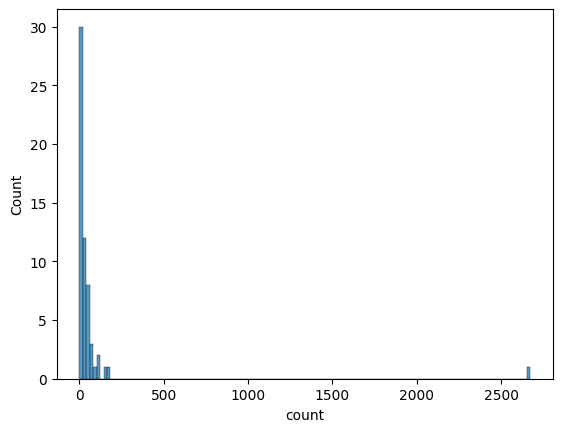

In [216]:
sns.histplot(df['yr_renovated'].value_counts())

# STEP 3: Feature Engineering.


Let's try to perform feature engineering to the Bedroom feature

In [217]:

number_of_bedrooms = {
            '<= 2': [0,1,2],
            '3' : [3] , 
            '4' :[ 4],
            '+5': [5,6,7,8,9]
}

# Create a reverse dictionary to map the number of bedrooms into the new bedrooms.
# Create the reverse dictionary
numbers_of_bedrooms = {bedroom: number for number, bedrooms in number_of_bedrooms.items() for bedroom in bedrooms}

# Map the 'round_bedrooms' column to regions and create a new column 'bedroom_in_houses'
df['bedroom_in_houses'] = df['bedrooms'].map(numbers_of_bedrooms)

# Count the occurrences of each region
bedroom_in_houses_counts = df['bedroom_in_houses'].value_counts()

print(bedroom_in_houses_counts)

bedroom_in_houses
3       2017
4       1492
<= 2     598
+5       393
Name: count, dtype: int64


Visualize the bedrooms with the feature engineering we have just perform


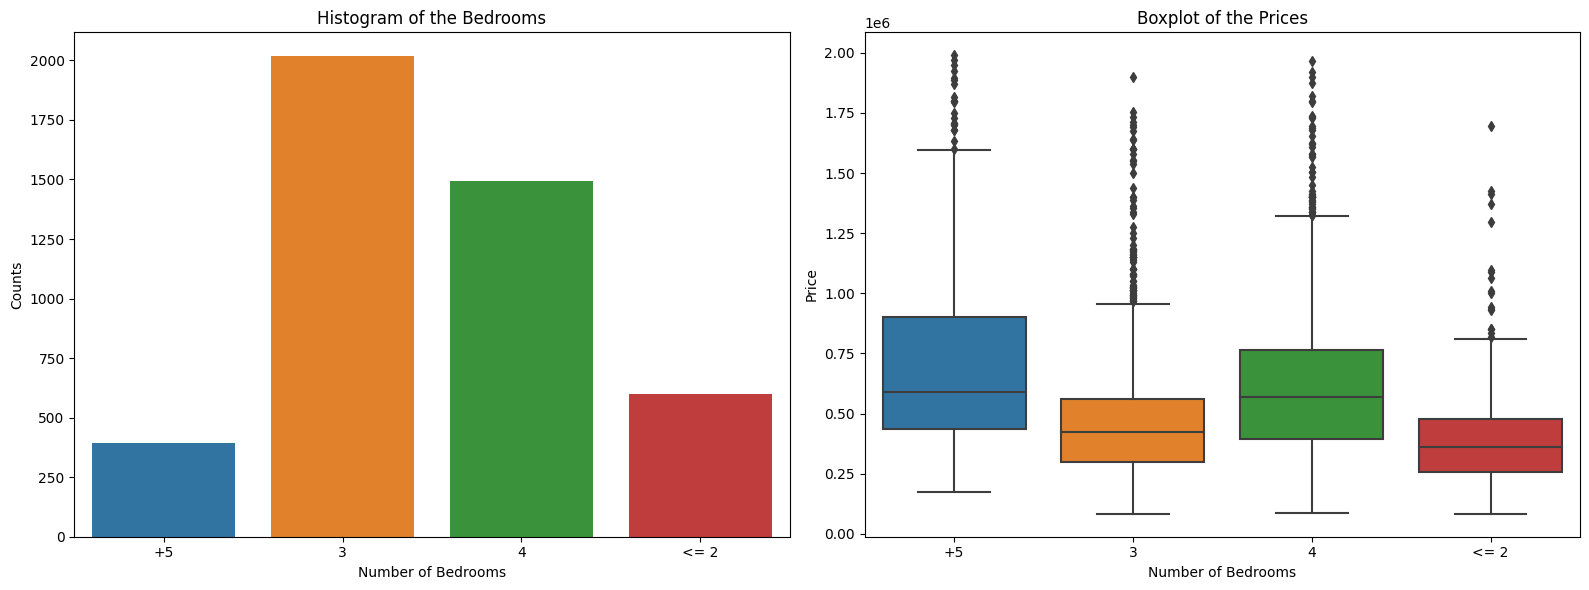

In [218]:
# Convert all values in 'bedroom_in_houses' to strings to ensure uniform type
df['bedroom_in_houses'] = df['bedroom_in_houses'].astype(str)

# Create a DataFrame with the counts of each 'bedroom_in_houses' value
bedroom_counts = df['bedroom_in_houses'].value_counts().sort_index().reset_index()
bedroom_counts.columns = ['bedroom_in_houses', 'counts']

# Ensure the 'bedroom_in_houses' column in the original DataFrame is a categorical type with ordered categories
bedroom_order = sorted(df['bedroom_in_houses'].unique())
df['bedroom_in_houses'] = pd.Categorical(df['bedroom_in_houses'], categories=bedroom_order, ordered=True)

# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot the sorted counts as a histogram
sns.barplot(x='bedroom_in_houses', y='counts', data=bedroom_counts, ax=ax[0])
ax[0].set_title('Histogram of the Bedrooms')
ax[0].set_xlabel('Number of Bedrooms')
ax[0].set_ylabel('Counts')

# Visualize the price per bedroom with a boxplot
sns.boxplot(data=df, x='bedroom_in_houses', y='price', ax=ax[1])
ax[1].set_title('Boxplot of the Prices')
ax[1].set_xlabel('Number of Bedrooms')
ax[1].set_ylabel('Price')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

Apply feature engineering to the bathroom feature


In [219]:
number_of_bathrooms = {
            '<= 1': [0,1],
            '2' : [2] , 
            '+3' :[3,4,5,6]}

# Create a reverse dictionary to map the number of bedrooms into the new bedrooms.
# Create the reverse dictionary
numbers_of_bathrooms = {bathroom: number for number, round_bathrooms in number_of_bathrooms.items() for bathroom in round_bathrooms}

# Map the 'round_bathrooms' column to regions and create a new column 'bathroom_in_houses'
df['bathroom_in_houses'] = df['round_bathrooms'].map(numbers_of_bathrooms)

# Count the occurrences of each region
bathroom_in_houses_counts = df['bathroom_in_houses'].value_counts()

print(bathroom_in_houses_counts)

bathroom_in_houses
2       2927
+3       818
<= 1     755
Name: count, dtype: int64


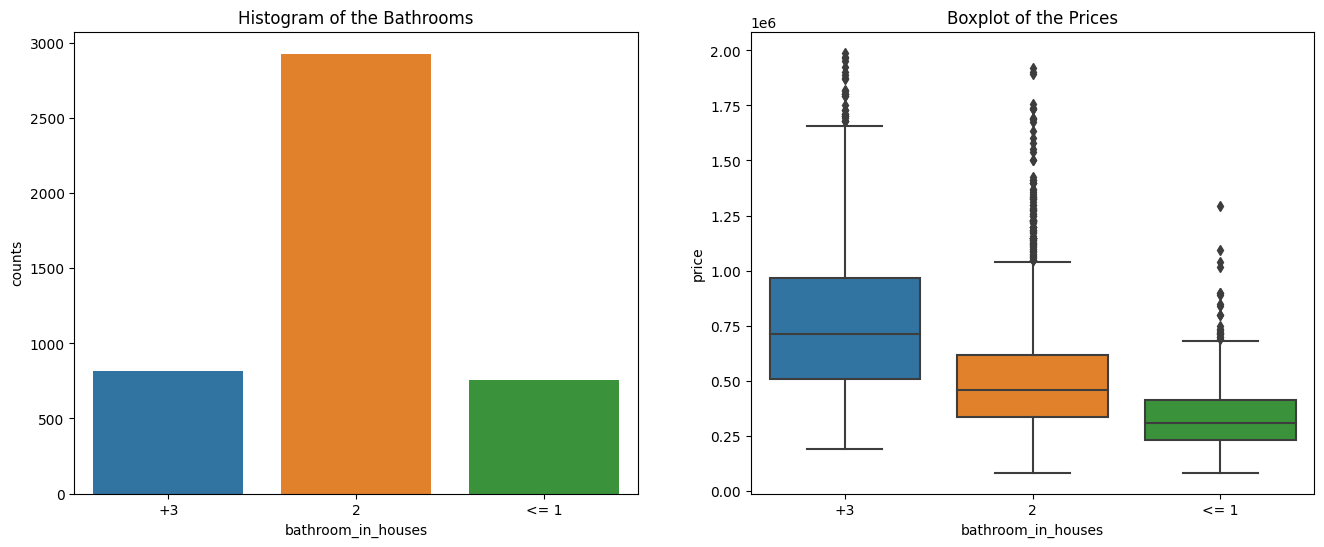

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [220]:
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Create a DataFrame with the counts of each 'bathroom_in_houses' value
bathroom_counts = df['bathroom_in_houses'].value_counts().sort_index().reset_index()
bathroom_counts.columns = ['bathroom_in_houses', 'counts']

# Ensure the 'bathroom_in_houses' column in the original DataFrame is a categorical type with ordered categories
bathroom_order = sorted(df['bathroom_in_houses'].unique())
df['bathroom_in_houses'] = pd.Categorical(df['bathroom_in_houses'], categories=bathroom_order, ordered=True)

# Plot the sorted counts as a histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='bathroom_in_houses', y='counts', data=bathroom_counts,ax = ax[0])
ax[0].set_title('Histogram of the Bathrooms')

# Visualize the price per bathroom with a boxenplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='bathroom_in_houses', y='price',ax = ax[1])
ax[1].set_title('Boxplot of the Prices')

# Adjust the layout
plt.tight_layout()

# Show the plots|
plt.show()

Check the amount of price per regions

In [221]:
# Create a dictionary based on the areas.
regions = {
    'West': ['Seattle', 'Bellevue', 'Redmond', 'Kirkland', 'Issaquah', 'Shoreline', 'Mercer Island', 'Burien', 'Kenmore', 'Des Moines', 'Lake Forest Park', 'Newcastle', 'Bothell', 'Vashon', 'SeaTac', 'Normandy Park'],
    'East': ['Renton', 'Kent', 'Auburn', 'Federal Way', 'Maple Valley', 'Covington', 'Enumclaw', 'Tukwila', 'Pacific', 'Algona'],
    'Central': ['Sammamish', 'Woodinville', 'Snoqualmie', 'North Bend', 'Duvall', 'Carnation', 'Fall City', 'Black Diamond', 'Ravensdale', 'Clyde Hill', 'Medina', 'Yarrow Point', 'Preston'],
    'North': ['Snoqualmie Pass', 'Inglewood-Finn Hill', 'Beaux Arts Village'],
    'South': ['Milton']
}

# Create a reverse dictionary to map cities to regions.
city_to_region = {city: region for region, cities in regions.items() for city in cities}

end_df = df.assign(regions = df['city'].map(city_to_region))
end_df.drop(['city'],axis = 1, inplace = True)

end_df['regions'].value_counts()

regions
West       2988
East        995
Central     509
North         3
South         2
Name: count, dtype: int64

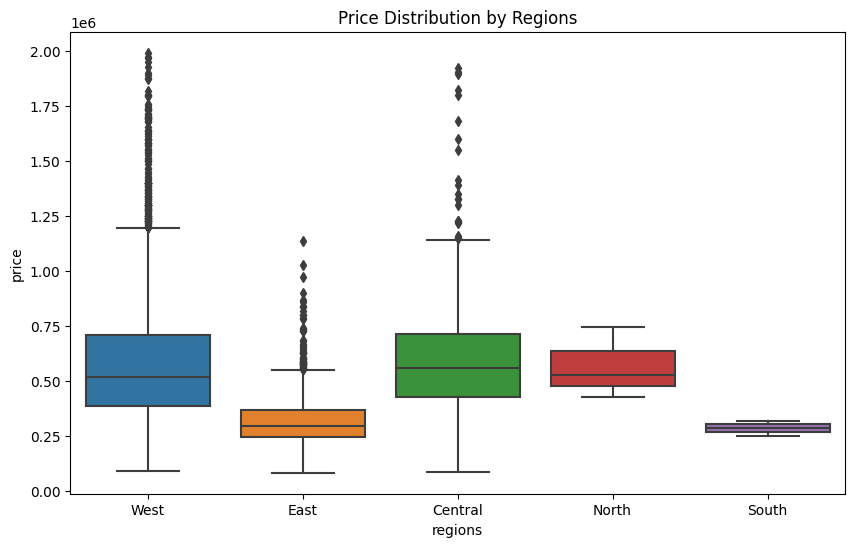

In [222]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=end_df, x='regions', y='price')
plt.title('Price Distribution by Regions')
plt.xlabel('regions')
plt.ylabel('price')
plt.show()


## Change the yr_renovated, view column.
## We assume that the zero values in this column means that the house has never been renovated. So we create a binary column, if a house has ever renovated we gave the value 1. 
## Also we assume the same thing in the view column. House with 0 value in the view column, is houses without view.

In [223]:
# The value 1 means that the house has renovated
end_df['renovated'] = np.where(end_df['yr_renovated'] != 0, 1, 0)

# Change the view column
end_df['view'] = np.where(end_df['view']!= 0 , 1, 0)

# Drop the yr_renovated column
end_df.drop(['yr_renovated'],axis = 1, inplace = True)

# We will also drop the watefront column, becasue the values is unbalanced.
# Alse drop the date column.
end_df.drop(['waterfront','date'],axis =1 , inplace = True )

## We can see that we don't have much information about the North and South houses, so this values will be droped.

In [224]:
new_df = end_df[(end_df['regions'] == 'West') | (end_df['regions'] == 'East') | (end_df['regions'] == 'Central')]
new_df
end_df = new_df

from scipy.stats import f_oneway, kruskal

# Assuming your dataframe is named end_df with columns 'regions' and 'price'

# ANOVA test
groups = [end_df['price'][end_df['regions'] == region] for region in end_df['regions'].unique()]
f_stat, p_value_anova = f_oneway(*groups)
print('ANOVA test results: F-statistic =', f_stat, ', p-value =', p_value_anova)

# Perform Kruskal-Wallis test
h_stat, p_value_kruskal = kruskal(*groups)
print('Kruskal-Wallis test results: H-statistic =', h_stat, ', p-value =', p_value_kruskal)

ANOVA test results: F-statistic = 378.97793882433405 , p-value = 8.27185095521833e-153
Kruskal-Wallis test results: H-statistic = 1016.6200371385162 , p-value = 1.7529270355000354e-221


# Prepare for modeling.
## Split the dataset to train, test and validation test.
## We will also use cross validation technique to validate our model.

## Create Dummies variables. 

In [241]:
df_transformed = pd.get_dummies(end_df,dtype=int,drop_first=True)


# Step 4: Multiple Linear Regression.

# We start our modeling by using multiple linear Regression.
## THe main focus is to increase the R square value and minimize the mean absolute error.

In [243]:
# After applying the Regression model to all the column, we can see that some of them are not significant.
# So we will drop them.
columns_to_drop = ['sqft_lot', 'price', 'months','bedrooms','renovated']

X = df_transformed.drop(columns_to_drop, axis = 1)
# Let's create a linear regression model based on the most correlated values.
X = sm.add_constant(X)

#y = end_df['price']
y = np.log(end_df['price'])

model = sm.OLS(y,X).fit()

In [244]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     598.9
Date:                Tue, 18 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:21:55   Log-Likelihood:                -845.71
No. Observations:                4492   AIC:                             1723.
Df Residuals:                    4476   BIC:                             1826.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      16.1432      0.415     38.923      0.000      15.330      16.956
bathrooms                   0.0916      0.018      5.184      0.000       0.057       0.126
sqft_living                 0.0002   6.14e-06     33.404      0.000       0.000       0.000
floors                      0.0701      0.011      6.132      0.000       0.048       0.092
view                        0.1554      0.016      9.640      0.000       0.124       0.187
condition                   0.0595      0.007      8.153      0.000       0.045       0.074
sqft_above                  0.0001   6.12e-06     24.305      0.000       0.000       0.000
sqft_basement            5.647e-05   8.49e-06      6.650      0.000    3.98e-05    7.31e-05
yr_built                   -0.0021      0.000    -10.164      0.000      -0.002      -0.002
round_bathrooms            -0.1096      0.024     -4.661      0.000      -0.156      -0.064
bedroom_in_houses_3         0.1343      0.019      7.261      0.000       0.098       0.171
bedroom_in_houses_4         0.1120      0.017      6.455      0.000       0.078       0.146
bedroom_in_houses_<= 2      0.1580      0.023      6.816      0.000       0.113       0.203
bathroom_in_houses_2       -0.0899      0.029     -3.102      0.002      -0.147      -0.033
bathroom_in_houses_<= 1    -0.3084      0.049     -6.235      0.000      -0.405      -0.211
regions_East               -0.3879      0.016    -23.697      0.000      -0.420      -0.356
regions_West                0.1255      0.015      8.311      0.000       0.096       0.155
==============================================================================
Omnibus:                      501.792   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1534.954
Skew:                          -0.583   Prob(JB):                         0.00
Kurtosis:                       5.616   Cond. No.                     9.53e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.22e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Let's try cross validation

In [245]:
def cross_val(X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)
    # Create a list to store validation scores for each fold

    cv_lm_tr_r2s = []
    cv_lm_tr_mae = []
    cv_lm_val_r2s = []
    cv_lm_val_mae = []
    
    for train_ind, val_ind in kf.split(X, y):
        # Subset data based on CV folds
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        # Fit the Model on fold's training data
        model = sm.OLS(y_train, X_train).fit()
        # Append Validation score to list 
        cv_lm_tr_r2s.append(r2_score(y_train, model.predict(X_train)))
        cv_lm_tr_mae.append(mean_absolute_error(y_train, model.predict(X_train)))
        cv_lm_val_r2s.append(r2_score(y_val, model.predict(X_val),))
        cv_lm_val_mae.append(mean_absolute_error(y_val, model.predict(X_val),))
        
        
    print(f"All Training R2s: {[round(x, 3) for x in cv_lm_tr_r2s]}")
    print(f"Training R2s: {round(np.mean(cv_lm_tr_r2s), 3)} +- {round(np.std(cv_lm_tr_r2s), 3)}")
    
    print(f"Training MAEs: {[round(x, 3) for x in cv_lm_tr_mae]}")
    print(f"Training MAEs: {round(np.mean(cv_lm_tr_mae), 3)} +- {round(np.std(cv_lm_tr_mae), 3)}")    
        
    print(f"All Validation R2s: {[round(x, 3) for x in cv_lm_val_r2s]}")
    print(f"Cross Val R2s: {round(np.mean(cv_lm_val_r2s), 3)} +- {round(np.std(cv_lm_val_r2s), 3)}")

    print(f"All Validation MAEs: {[round(x, 3) for x in cv_lm_val_mae]}")
    print(f"Cross Val MAEs: {round(np.mean(cv_lm_val_mae), 3)} +- {round(np.std(cv_lm_val_mae), 3)}")
    
    return model
    
model = cross_val(X, y, 5)

All Training R2s: [0.667, 0.668, 0.667, 0.664, 0.673]
Training R2s: 0.668 +- 0.003
Training MAEs: [0.217, 0.216, 0.216, 0.218, 0.216]
Training MAEs: 0.216 +- 0.001
All Validation R2s: [0.668, 0.666, 0.665, 0.678, 0.645]
Cross Val R2s: 0.664 +- 0.011
All Validation MAEs: [0.216, 0.221, 0.221, 0.211, 0.219]
Cross Val MAEs: 0.217 +- 0.004


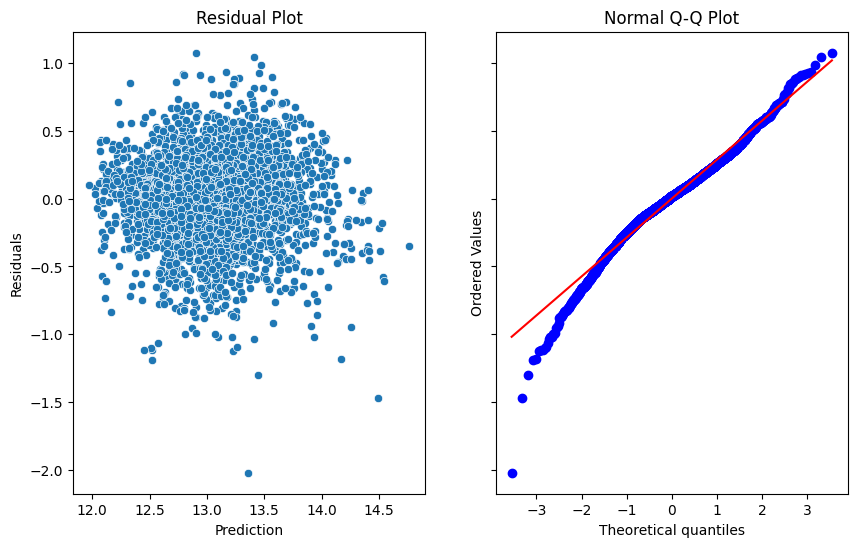

In [246]:
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")   
residual_analysis_plots(model)

# Step 5: Regularization Regression

In [231]:
# Data Splitting
X = sm.add_constant(df_transformed.drop(columns_to_drop, axis=1))
y = df_transformed["price"]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=2023)

In [232]:
# Standardization
std = StandardScaler()
X_tr = std.fit_transform(X_train.values)
X_val = std.transform(X_valid.values)
X_te = std.transform(X_test.values)

In [233]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1).fit(X_tr, y_train)

list(zip(X.columns, ridge_model.coef_))

[('const', 0.0),
 ('bathrooms', 18919.989424477855),
 ('sqft_living', 96038.62359367656),
 ('floors', 21710.785327274058),
 ('view', 34382.60056979163),
 ('condition', 21763.16118779892),
 ('sqft_above', 92310.68892365812),
 ('sqft_basement', 20575.06348408039),
 ('yr_built', -45981.18327705129),
 ('round_bathrooms', 5405.709977662811),
 ('bedroom_in_houses_+5', -18847.606671824105),
 ('bedroom_in_houses_3', 6357.141856531118),
 ('bedroom_in_houses_4', -6600.374499593948),
 ('bedroom_in_houses_<= 2', 15314.179237101593),
 ('bathroom_in_houses_+3', 7536.954060356508),
 ('bathroom_in_houses_2', -271.74034628537527),
 ('bathroom_in_houses_<= 1', -7219.88540431596),
 ('regions_Central', 5894.420425613446),
 ('regions_East', -54655.7762548124),
 ('regions_West', 44157.873896068144)]

In [234]:
from sklearn.metrics import r2_score as r2

r2(y_test, ridge_model.predict(X_test))


-1221524.828561855

In [235]:
std = StandardScaler()
X_m = std.fit_transform(X.values)
X_te = std.transform(X_test.values)
ridge_model.score(X_m, y)

0.6308096796937608

In [236]:
# Define the parameter grid
parameters = {
    "alpha": np.linspace(0.1, 2, 20),  # Regularization strength
    "l1_ratio": [0, 0.5, 1]  # 0 for Ridge, 1 for Lasso, 0.5 for ElasticNet
}

# Initialize the model
elastic_net = ElasticNet()

# Set up the GridSearchCV
gridsearch = GridSearchCV(elastic_net, parameters, cv=5)  # Added cv for cross-validation

# Fit the model
gridsearch.fit(X_tr, y_train)

# Print the best parameters
print(gridsearch.best_params_)


{'alpha': 2.0, 'l1_ratio': 1}


In [237]:
# Initialize the Lasso model with the best parameters
best_lasso = Lasso(alpha=2.0)

# Fit the model on the training data
best_lasso.fit(X_tr, y_train)

# Now you can use this model to make predictions
y_pred = best_lasso.predict(X_te)

print(best_lasso.score(X_tr,y_train))

0.642108477487498


# Step 5: Apply Decission Trees, Random Forest Regressor and Gradient Boosting Regressor

In [238]:
model = DecisionTreeRegressor(max_depth=6)

model.fit(X, y)

print(model.score(X, y))
print(model.score(X_test, y_test))

0.6712116240196262
0.5893265816141031


In [239]:
rf = RandomForestRegressor(min_samples_leaf=5, n_estimators=1000, random_state=2023)

model = rf.fit(X, y)

print(model.score(X, y))
print(model.score(X_test, y_test))

0.805886795362968
0.6480804678819607


In [240]:
gb = GradientBoostingRegressor(min_samples_leaf=5, n_estimators=50, random_state=2023)

model = gb.fit(X, y)

print(model.score(X, y))
print(model.score(X_test, y_test))

0.6948974685587728
0.6465147522997443


In [249]:
'''# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Initialize the GradientBoostingRegressor
gb = GradientBoostingRegressor(random_state=2023)

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Extract the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)

print("Test set score: ", test_score)'''

'# Define the parameter grid\nparam_grid = {\n    \'n_estimators\': [50, 100, 150],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'max_depth\': [3, 4, 5],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 5]\n}\n\n# Initialize the GradientBoostingRegressor\ngb = GradientBoostingRegressor(random_state=2023)\n\n# Initialize GridSearchCV with the model and parameter grid\ngrid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring=\'neg_mean_squared_error\', n_jobs=-1, verbose=2)\n\n# Fit GridSearchCV on the training data\ngrid_search.fit(X_train, y_train)\n\n# Extract the best parameters and best score\nbest_params = grid_search.best_params_\nbest_score = grid_search.best_score_\n\n# Print the best parameters and best score\nprint("Best parameters found: ", best_params)\nprint("Best cross-validation score: ", best_score)\n\n# Evaluate the best model on the test set\nbest_model = grid_search.best_estimator_\ntest_score = best_model.score(X_test

In [248]:
# Create a new GradientBoostingRegressor with the best parameters
best_gb = GradientBoostingRegressor(**best_params, random_state=2023)

# Fit the model on the training data
best_model = best_gb.fit(X_train, y_train)

# Evaluate the model on the training data
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

# Print the training and test scores
print("Training set score: ", train_score)
print("Test set score: ", test_score)

Training set score:  0.7373751661371242
Test set score:  0.6567867240486439
